# 2. Clustering
In this exercise, we will extract features from metascientific-article titles/abstracts for the purpose of clustering the articles. We will also use the features to try to predict how many citations the articles received. We will make use of a dataset of 1,124 articles obtained using the following query on Scopus: `"science of science" OR "metascience" OR "meta science"`.

## Environment Setup

In [ ]:
import sys
if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Install requisite packages
    !pip install sentence_transformers pacmap &> /dev/null

    # Change working directory
    %cd /content/drive/MyDrive/LLM4SciSci

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from pacmap import PaCMAP
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Feature Extraction
The code begins by loading the data as `pandas.DataFrame` objects and concatenating the titles and abstracts into a single column (`'text'`).

In [2]:
# Load the data with only the desired columns
data = pd.read_csv('science_of_science.csv', usecols=['title', 'abstract', 'keywords', 'year', 'citations'])

# Concatenate titles and abstracts
data['text'] = data['title'] + './n/n' + data['abstract']
data

,title,abstract,keywords,year,citations,text
0,Machine learning misclassification networks re...,Given a large enough volume of data and precis...,Interdisciplinary research; Machine learning; ...,2024,3,Machine learning misclassification networks re...
1,Dynamic patterns of the disruptive and consoli...,Scientific breakthroughs possess the transform...,citation network; disruption; Nobel Prize; sci...,2024,2,Dynamic patterns of the disruptive and consoli...
2,Automating the practice of science: Opportunit...,Automation transformed various aspects of our ...,AI for science; automation ; computational sci...,2025,1,Automating the practice of science: Opportunit...
3,Asian American Representation Within Psycholog...,"As a racial group, Asians are incredibly diver...",Asian/Asian American; diversity; intersectiona...,2024,1,Asian American Representation Within Psycholog...
4,Bibliometric analysis of publications on trabe...,"Purpose: Trabecular bone score (TBS), as a tex...",Bone mineral density; Fracture risk; Knowledge...,2024,0,Bibliometric analysis of publications on trabe...
...,...,...,...,...,...,...
1119,The science of science foundation,[No abstract available],NaN,1965,1,The science of science foundation./n/n[No abst...
1120,Bibliographic coupling: A review,The theory and practical applications of bibli...,NaN,1974,224,Bibliographic coupling: A review./n/nThe theor...
1121,Behavioristisk kritik av psykoanalysen,"As fas as metascience is concerned, Schioldbor...",NaN,1971,3,Behavioristisk kritik av psykoanalysen./n/nAs ...
1122,The R & D information gap or the social scienc...,[No abstract available],NaN,1967,0,The R & D information gap or the social scienc...


It next initializes the `SentenceTransformer` model `'all-MiniLM-L6-v2'` and extracts features from the training data using the `.encode()` method.

In [4]:
# Initialize feature extraction pipeline
model = SentenceTransformer('all-MiniLM-L6-v2')

# Extract features
features = model.encode(data['text'], show_progress_bar=True)
features

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

array([[-0.00473206, -0.04576412,  0.01965012, ..., -0.03477446,
         0.02810462,  0.01813718],
       [-0.05819887, -0.06011161,  0.02259039, ..., -0.06635984,
         0.05790947,  0.03990703],
       [-0.06759556,  0.02921594, -0.0322248 , ...,  0.00199628,
         0.01664495, -0.01207595],
       ...,
       [ 0.02056852,  0.00477816, -0.08616947, ...,  0.10622985,
         0.02579156, -0.02725776],
       [ 0.00344623,  0.02273844, -0.06633328, ...,  0.01183059,
        -0.0287214 ,  0.07119869],
       [-0.05497676,  0.01687015, -0.01583676, ..., -0.051455  ,
         0.03415811, -0.0143118 ]], dtype=float32)

To visualize the article features (and reduce their dimensionality for clustering downstream), the code initializes a `PaCMAP` object and uses it to project the features into 3 components.

In [5]:
# Initialise PaCMAP with random_state=42 for reproducibility
pacmap_3d = PaCMAP(n_components=3, random_state=42)

# Project features into 3 dimensions
features_3d = pacmap_3d.fit_transform(features)
features_3d

Note: `n_components != 2` have not been thoroughly tested.


array([[-5.1307797 ,  0.7222768 , -2.1033096 ],
       [-4.9588923 , -0.52778226,  0.01230745],
       [ 2.5149417 ,  0.05208392, -0.27041626],
       ...,
       [ 4.750076  ,  0.2043146 , -0.9815626 ],
       [ 0.49959773,  0.65048563,  0.35322475],
       [ 4.8895655 ,  1.0077091 , -2.3629692 ]], dtype=float32)

These components can then be visualized using `matplotlib`'s 3-d plotting functionality:

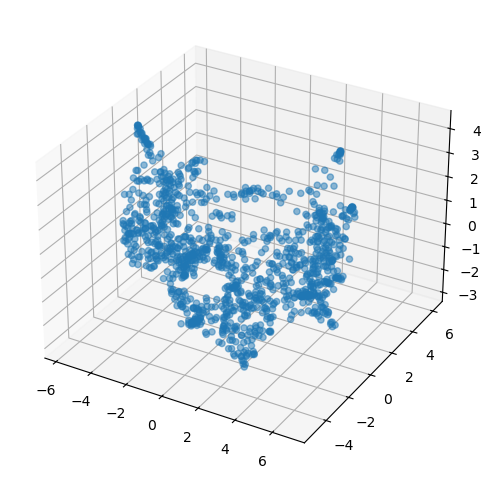

In [6]:
# Plot features using scatterplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], alpha=.5)

## Clustering
The code next clusters the features into 5 groups using `sklearn`'s [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html):

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


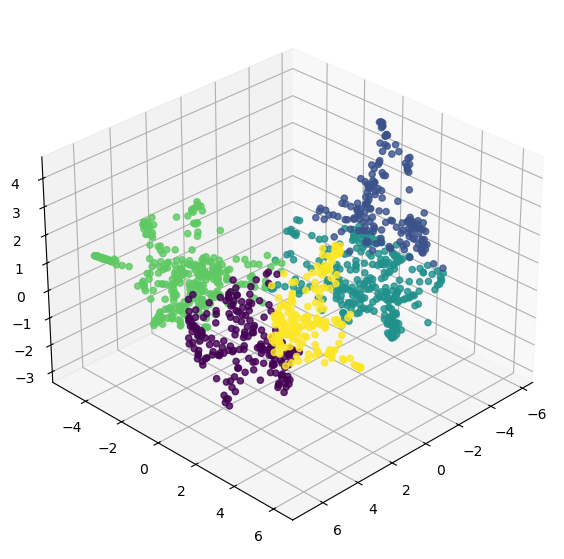

In [7]:
# Cluster using KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(features_3d)

# Plot clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],    # x, y, z
    c=kmeans.labels_,   # Color with cluster labels
    cmap="viridis", alpha=.8
)
# Rotate the plot
ax.view_init(elev=30, azim=45)  # Adjust angles as needed

**Task 1**: Try adjusting the `elev` (elevation angle), `azim` (horizontal rotation), and `alpha` (opacity, [0,1]) parameters above to get a better intuition for the clusters' 3-dimensional structure.

The code next save the cluster labels as a new column (`'cluster'`) in `data` and saves the results to a new csv file in your Google Drive for reuse in the next exercise.

In [8]:
# Saving the clusters for 3_text_generation
data['cluster'] = pd.Series(kmeans.labels_, dtype=str)
data.to_csv('science_of_science_clusters.csv', index=False)

In order to give the clusters meaningful labels, we can make use of the `'keywords'` column. Specifically, the code counts the number of times each key word occurs in each cluster, and saves the results to `cluster_keyword_counts`. These counts can be used to characterize the clusters in terms of their most informative keywords.

In [9]:
cluster_keyword_counts = {} # Dictionary for storing keyword counts in each cluster
unique_keywords = set() # Set for storing all unique keywords

# Iterate through each cluster, count the frequency of each keyword
for cluster in data['cluster'].unique():

    # Select rows for the given cluster
    cluster_data = data.query('cluster == @cluster')

    # Concatenate all keywords into a single string, remove surrounding whitespace, and lowercase
    keywords = cluster_data['keywords'].str.cat(sep='').split(';')
    keywords = [keyword.strip().lower() for keyword in keywords]

    # Save unique keywords
    unique_keywords = unique_keywords.union(set(keywords))

    # Count the frequency of each keyword and save to cluster_keyword_counts
    keyword_counts = Counter(keywords)
    cluster_keyword_counts[cluster] = {keyword.strip().lower(): count for keyword, count in keyword_counts.items()}

# Printing the number of keywords for each cluster
{cluster: len(keywords) for cluster, keywords in cluster_keyword_counts.items()}

{'2': 756, '0': 518, '3': 736, '1': 450, '4': 477}

The code next reshapes the data in `cluster_keyword_counts` into a `pd.DataFrame` where each row represents a cluster, each column a keyword, and each cell the number of times that keyword occurs in that cluster. It also drops rare words (words occuring <= 3 times) to prevent them from distorting/inflating our pointwise mutual information estimates in the next step.

In [10]:
# Building cluster-keyword count matrix
count_matrix = pd.DataFrame(index=cluster_keyword_counts.keys(), columns=list(unique_keywords))
for cluster in count_matrix.index:
    for keyword in count_matrix.columns:
        count_matrix.loc[cluster, keyword] = cluster_keyword_counts[cluster].get(keyword, 0)

count_matrix = count_matrix.astype(int) # Convert to int format
count_matrix = count_matrix.loc[:, count_matrix.sum() > 3] # Drop keywords occurring <=3 times
count_matrix

,matthew effect,diagnostic testing,social network analysis,open science,mechanical ventilation,ontology,covid-19,science communication,citation networks,data analytics,...,bibliometrics,topic detection,data mining,citation analysis,science of science,high-skilled migration,research impact,neuroscience,monitoring,citations
2,0,0,0,1,0,3,3,0,6,2,...,6,5,3,3,81,0,3,2,0,3
0,1,4,1,1,4,2,0,0,0,1,...,0,0,0,0,9,0,0,3,4,0
3,0,0,0,39,0,0,3,9,0,0,...,0,0,0,0,10,0,0,0,0,0
1,4,0,3,0,0,1,0,0,0,1,...,1,0,1,4,75,4,1,0,0,2
4,0,0,0,2,0,0,0,2,0,0,...,3,0,0,0,24,0,0,0,0,0


Although we could in-principle already use the `count_matrix` to characterize the clusters, it's likely that high-frequency, less informative keywords end up dominating these characterizations. Instead, the code transform the `count_matrix` by taking the pointwise mutual information (PMI), which ["draws on the intuition that the best way to weigh the association between two words [, or a word and its cluster,] is to ask how much more the two words co-occur in a corpus than we would have expected them to appear by chance."](https://en.wikipedia.org/wiki/Pointwise_mutual_information).

In [11]:
def compute_pmi(df):

    mat = df.to_numpy(dtype=np.float64)  # Convert DataFrame to NumPy array
    p = mat / np.sum(mat)  # Compute probability matrix

    row_sums = np.sum(p, axis=1, keepdims=True)
    col_sums = np.sum(p, axis=0, keepdims=True) ** 0.7

    expected = row_sums @ col_sums  # Outer product of row and column sums
    pmi = p / expected  # Compute PMI matrix (don't take log since we only care about order in next part)

    return pd.DataFrame(pmi, index=df.index, columns=df.columns)


# Compute pmi
pmi_matrix = compute_pmi(count_matrix)
pmi_matrix

,matthew effect,diagnostic testing,social network analysis,open science,mechanical ventilation,ontology,covid-19,science communication,citation networks,data analytics,...,bibliometrics,topic detection,data mining,citation analysis,science of science,high-skilled migration,research impact,neuroscience,monitoring,citations
2,0.000000,0.000000,0.000000,0.032445,0.000000,0.386356,0.386356,0.000000,0.772712,0.342106,...,0.540410,0.731583,0.513159,0.346837,0.899208,0.000000,0.513159,0.292633,0.000000,0.438950
0,0.324575,1.517793,0.379448,0.071973,1.517793,0.571372,0.000000,0.000000,0.000000,0.379448,...,0.000000,0.000000,0.000000,0.000000,0.221636,0.000000,0.000000,0.973726,1.517793,0.000000
3,0.000000,0.000000,0.000000,0.922648,0.000000,0.000000,0.281718,0.552926,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.080947,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.837995,0.000000,0.734750,0.000000,0.000000,0.184397,0.000000,0.000000,0.000000,0.244917,...,0.128962,0.000000,0.244917,0.662143,1.192132,0.979666,0.244917,0.000000,0.000000,0.418997
4,0.000000,0.000000,0.000000,0.252348,0.000000,0.000000,0.000000,0.655319,0.000000,0.000000,...,1.050798,0.000000,0.000000,0.000000,1.036124,0.000000,0.000000,0.000000,0.000000,0.000000


With the PMI estimates computed, the clusters can now be characterized by taking the 5 highest-PMI keywords:

In [12]:
# Get top 5 highest-PMI keywords
top_keywords = pmi_matrix.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)
top_keywords.to_dict()

{'2': ['science of science',
  'scholarly data',
  'machine learning',
  'citation networks',
  'scientometrics'],
 '0': ['diagnostic testing',
  'mechanical ventilation',
  'respiratory muscles',
  'serendipity',
  'randomized clinical trials'],
 '3': ['open science',
  'metascience',
  'replication',
  'meta-science',
  'replicability'],
 '1': ['science of science',
  'research funding',
  'novelty',
  'high-skilled migration',
  'gender'],
 '4': ['knowledge',
  'history of science',
  'science',
  'epistemology',
  'philosophy of science']}

The resulting clusters appear relatively coherent and informative. Nevertheless, there may be better ways to characterize the clusters. There may also be situations where we don't have access to a handy set of keywords. Can you think of other ways to characterize the clusters (e.g., using LLMs instead of co-occurence statistics)?

## Prediction

In this section, we will leverage the features (and the rough age of the article) to try to predict the number of citations the articles received. The code begins by converting the features to a `pd.DataFrame` and appending the age of the article as an additional predictor variable.

In [13]:
features = pd.DataFrame(features)
features['age'] = data['year'].max() - data['year']
features.columns = [str(name) for name in features.columns]
features

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,age
0,-0.004732,-0.045764,0.019650,0.065773,0.028566,-0.036886,-0.031429,-0.036337,0.017890,0.005857,...,0.014080,0.012025,-0.025179,-0.043409,0.035584,0.117944,-0.034774,0.028105,0.018137,1
1,-0.058199,-0.060112,0.022590,0.069626,0.091841,0.019990,-0.001638,0.019873,0.143764,0.032049,...,0.088258,-0.022649,0.037498,-0.030889,-0.035279,0.132068,-0.066360,0.057909,0.039907,1
2,-0.067596,0.029216,-0.032225,0.034270,-0.007039,-0.038817,-0.050086,0.037803,-0.060357,0.034443,...,0.063522,0.027763,-0.024253,-0.017212,0.051543,0.050299,0.001996,0.016645,-0.012076,0
3,0.023968,0.073681,-0.017741,0.056319,0.010937,0.027688,-0.026650,-0.040827,0.081435,-0.021363,...,-0.005026,0.050209,0.005980,-0.003021,0.016673,0.134889,0.117325,-0.056097,0.039172,1
4,0.013449,-0.012272,-0.027512,0.015636,-0.036815,-0.031232,-0.032198,0.134578,-0.013309,0.149826,...,0.111134,0.057578,0.006051,-0.011187,-0.021133,0.082459,-0.079954,0.021188,0.019885,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,-0.065067,-0.012515,-0.028379,0.043236,0.068649,-0.045498,-0.060979,0.019548,-0.013149,0.028463,...,0.028144,-0.032783,-0.048252,-0.078154,-0.015838,0.114345,-0.022164,0.091272,0.034125,60
1120,0.032951,-0.033119,-0.106345,-0.008057,-0.048597,0.019214,-0.031293,0.032615,0.053004,-0.001087,...,-0.015819,-0.010489,-0.019691,0.033168,-0.005141,0.085022,-0.060551,0.077803,0.002807,51
1121,0.020569,0.004778,-0.086169,0.017474,0.013938,0.059193,0.004880,0.072674,0.089914,0.018105,...,0.041340,0.045986,0.013729,-0.112301,0.001531,0.113347,0.106230,0.025792,-0.027258,54
1122,0.003446,0.022738,-0.066333,0.051622,0.094185,0.019273,-0.105864,0.026692,-0.006689,0.048947,...,-0.020242,-0.016438,0.012716,-0.080422,-0.018237,0.069241,0.011831,-0.028721,0.071199,58


The data is next split into a training and test set using `sklearn`'s [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). The features are then standardised before being fed into `RidgeCV`. This is crucial, since `RidgeCV` uses l2 (ridge) regularisation to prevent over-fitting, which assumes that the features have the same scaling. The regression is then trained on the training data using the `fit` method. Note that `RidgeCV` will automatically perform cross-validation on the training data to find the best alpha value from the list of `alphas` provided. Performance on the training data is then evaluated using the `score` method.

In [14]:
# Splitting data into a training (80%) and test (20%) to evaluate out-of-sample performance
X_train, X_test, y_train, y_test = train_test_split(
    features, np.log1p(data['citations']), test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Initialize classifier
ridge = RidgeCV(alphas=np.logspace(-10, 10, 100))

# Train classifier
ridge.fit(X_train, y_train)
f"Train accuracy: {ridge.score(X_train, y_train):.2f}"

'Train accuracy: 0.29'

Features are next extracted for the test set and standardised using the same `StandardScaler` object that was fitted on the training data to prevent data leakage. The regression is then evaluated on the test data using the `score` method.

In [15]:
# Standardising features
X_test = scaler.transform(X_test)

# Test classifier
f"Test accuracy: {ridge.score(X_test, y_test):.2f}"

'Test accuracy: 0.06'

## General tasks


**TASK 2:** Go to the `SentenceTransformers` [model page](https://sbert.net/docs/sentence_transformer/pretrained_models.html) and find a model of a slightly larger size than  `'all-MiniLM-L6-v2'` (e.g. `all-mpnet-base-v2'`). Open the Hugging Face model card by clicking on the model name and then the link next to 'Model Card'. Replace the `'all-MiniLM-L6-v2` in the code above with the models name (make sure to copy the full name by clicking on the copy-icon to the right of the name at the top of the page). Re-run the entire analysis. Do the article clusters change? Does predictive performance improve?

**TASK 3 (BONUS):** Consider how you might apply the above methods in your own research. If you have dataset in mind, try uploading it to the repository in your Google Drive and loading it into this notebook to run the analysis with your own data (**Caution**: make sure you don't delete the original `science_of_science.csv` dataset, as we will need it for the next exercise).

